In [1]:
# Change ComplexNets.py directory so we can use it in Kaggle as a library

# import module we'll need to import our custom module
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/newcomplex-fixissues-2/ComplexNets.py", dst = "../working/ComplexNets.py")
copyfile(src = "../input/non-local/non_local.py", dst = "../working/non_local.py")

'../working/non_local.py'

In [2]:
%%time 

# data path
my_path = '../input/data-skripsi-2'


import os
import gc

from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.linewidth'] = 0

import numpy as np
import pickle
import h5py
import cv2
import tensorflow as tf
from keras.layers import Input, Reshape, Dense,AveragePooling2D, UpSampling2D, Conv2D, Flatten, PReLU, Lambda, Conv1D, MaxPooling2D,Dropout
from keras.models import Model
from keras.initializers import RandomUniform
from keras.engine.topology import Layer
from keras.constraints import *
from keras.optimizers import SGD
from keras.callbacks import *

from ComplexNets import *
from non_local import non_local_block
import subprocess
import imageio
from IPython.display import HTML

def axes_off():
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)
    
new_folders = ['figures', 'gifs', 'logs', 'models', 'tables', 'triptychs', 'weights']
for new_folder in new_folders:
    if not os.path.isdir(new_folder): 
        os.makedirs(new_folder)

CPU times: user 1.85 s, sys: 539 ms, total: 2.39 s
Wall time: 5.35 s


In [3]:
import timeit

device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Load Data

In [4]:
out_dim = 28
speckle_dim = 28
image_dim = speckle_dim
Use_root    = False
phase_shift = False


file_location = '../input/data-skripsi/Data_1m.h5'
hf = h5py.File(file_location , 'r')

## Put in Numpy Array (target variable)

In [5]:
# Original/input image filenames
orig_img_filenames =  {'digi': 'Training/Original_images/MNIST',
                      'fash': 'Training/Original_images/Fashion-MNIST',
                      'fash_test': 'Testing/Original_images/MNIST',
                      'digi_test': 'Testing/Original_images/Fashion-MNIST',
                       'punc': 'Testing/Original_images/Muybridge Punch'
                      }

orig_imgs = {dataset: None for dataset in orig_img_filenames}


for dataset, filename in orig_img_filenames.items():
    # Load
    fl = hf[filename]
    orig_imgs[dataset] =  np.array(fl)
    
    
## TRAIN
y_train = np.concatenate((orig_imgs['digi'][:10000],
                          orig_imgs['fash'][:10000],
                         ))

y_train = np.squeeze(y_train.reshape(-1, out_dim*out_dim, 1))

## VALID
y_valid = np.concatenate((orig_imgs['digi'][10000:],
                          orig_imgs['fash'][10000:],
                         ))


y_valid = np.squeeze(y_valid.reshape(-1, out_dim*out_dim, 1))

## TEST
y_test = np.concatenate((orig_imgs['digi_test'],
                         orig_imgs['fash_test'],
                        orig_imgs['punc']))

y_test = np.squeeze(y_test.reshape(-1, out_dim*out_dim, 1))

In [6]:
y_valid.shape, y_train.shape , y_test.shape

((4000, 784), (20000, 784), (6012, 784))

## Put in Numpy Array (X variable)

In [7]:
# Load and resize all datasets

# Original/input image filenames
speckle_img_filenames =  {'digi': 'Training/Speckle_images/MNIST',
                      'fash': 'Training/Speckle_images/Fashion-MNIST',
                      'fash_test': 'Testing/Speckle_images/MNIST',
                      'digi_test': 'Testing/Speckle_images/Fashion-MNIST',
                      'punc': 'Testing/Speckle_images/Muybridge Punch'
                      }

data_dict = {dataset: None for dataset in speckle_img_filenames}

# import speckle images and resize them from 224 to the chosen speckle_dim
for dataset, filename in speckle_img_filenames.items():
    print(f"Loading {dataset} ...")
    # Load
    fl = hf[filename]
    data_dict[dataset] =  np.array(fl)
    # To resize we recover the original image shape
    Data_resize = np.reshape(data_dict[dataset], (data_dict[dataset].shape[0],224,224) )
    Data_temp = np.zeros((data_dict[dataset].shape[0],speckle_dim*speckle_dim))
    # Resize
    for im in range(data_dict[dataset].shape[0]):

        Data_temp[im] = np.reshape(cv2.resize(Data_resize[im], dsize=(speckle_dim, speckle_dim), interpolation=cv2.INTER_AREA), (speckle_dim*speckle_dim))
    
    data_dict[dataset] = Data_temp            
    del Data_temp, Data_resize
    gc.collect()

Loading digi ...
Loading fash ...
Loading fash_test ...
Loading digi_test ...
Loading punc ...


## Merged All datasets (X variable)

In [8]:
# TRAIN
x_train = np.concatenate((data_dict['digi'][:10000],
                          data_dict['fash'][:10000],
                         ))

# VALID
x_valid = np.concatenate((data_dict['digi'][10000:],
                          data_dict['fash'][10000:],
                         ))

# TEST
x_test = np.concatenate((data_dict['digi_test'], data_dict['fash_test'],data_dict['punc']))

# Change into complex fields
x_train_ch = real_to_channels_np(x_train.astype('float32'))
x_valid_ch = real_to_channels_np(x_valid.astype('float32'))
x_test_ch  = real_to_channels_np(x_test.astype('float32'))


hf.close()

In [9]:
# import statistics
# output = statistics.variance(x_train[0])
# print(output)

In [10]:
# for i in range(100):
#     output = statistics.variance(x_train[i])
#     print(output)

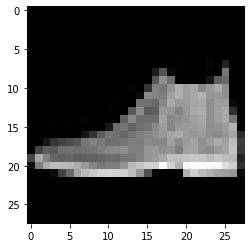

In [11]:
tes_image = orig_imgs["digi_test"][0].reshape(28,28)
plt.imshow(tes_image)

In [12]:
x_test.shape, x_train.shape, x_valid.shape

((6012, 784), (20000, 784), (4000, 784))

# Apply the nonlinear transformation that the SLM induces on amplitude and phase

In [13]:
from scipy import interpolate
experimentalAmp   = np.load(my_path + '/amplitude.npy')
experimentalPhase = np.load(my_path + '/phase.npy')
experimentalPhase = np.append(experimentalPhase, experimentalPhase[-2] ) # add in missing datapoint

x1 = np.arange(0.0,101.0)/100.0
x2 = np.arange(0.0,101.0)/100.0
print(len(experimentalPhase), len(x2))
testx = np.arange(0.0,100.0,0.5)/100.0
fSLMamp = interpolate.interp1d(x1, experimentalAmp/np.max(experimentalAmp))
fSLMphase = interpolate.interp1d(x2, experimentalPhase)


print(np.min(y_train), np.max(y_train), np.max(y_valid))
y_train_phase = fSLMphase(y_train)*255.0
y_valid_phase = fSLMphase(y_valid)*255.0
y_test_phase  = fSLMphase(y_test)*255.0
y_train       = fSLMamp(y_train)*255.0
y_valid       = fSLMamp(y_valid)*255.0
y_test        = fSLMamp(y_test)*255.0
print(np.min(y_train), np.max(y_train),np.max(y_valid))

101 101
0.0 1.0 1.0
3.113248752079867 255.0 255.0


# Modelling

## Hadamard Layer

In [14]:
class Hadamard2(Layer):
    # creates a custom layer for elementwise multiplying every element of a vector by another weight vector
    # assumes input is complex in separate real and imaginary channels
    def __init__(self, kernel_constraint=None, **kwargs):
        super(Hadamard2, self).__init__(**kwargs)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
 
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(1,input_shape[1]),
                                      initializer=keras.initializers.Constant(value=1.0),
                                      constraint=self.kernel_constraint,
                                      trainable=True)
        super(Hadamard2, self).build(input_shape)  # Be sure to call this somewhere!
 
    def call(self, x):
        if tf.keras.backend.ndim(x) == 3:
            return complex_to_channels(channels_to_complex(x) * 
                                       tf.complex(self.kernel, 0*self.kernel))
        else:
            return x*self.kernel
        
    def get_config(self):
        config = {
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint)
        }
        base_config = super(Hadamard2, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
 
    def compute_output_shape(self, input_shape):
        return input_shape

## Non-local Layer

In [15]:
from keras.layers import Activation, Reshape, Lambda, dot, add
from keras.layers import Conv1D, Conv2D, Conv3D
from keras.layers import MaxPool1D
from keras import backend as K


def non_local_block(ip, intermediate_dim=None, compression=2,
                    mode='embedded', add_residual=True):
    """
    Adds a Non-Local block for self attention to the input tensor.
    Input tensor can be or rank 3 (temporal), 4 (spatial) or 5 (spatio-temporal).
    Arguments:
        ip: input tensor
        intermediate_dim: The dimension of the intermediate representation. Can be
            `None` or a positive integer greater than 0. If `None`, computes the
            intermediate dimension as half of the input channel dimension.
        compression: None or positive integer. Compresses the intermediate
            representation during the dot products to reduce memory consumption.
            Default is set to 2, which states halve the time/space/spatio-time
            dimension for the intermediate step. Set to 1 to prevent computation
            compression. None or 1 causes no reduction.
        mode: Mode of operation. Can be one of `embedded`, `gaussian`, `dot` or
            `concatenate`.
        add_residual: Boolean value to decide if the residual connection should be
            added or not. Default is True for ResNets, and False for Self Attention.
    Returns:
        a tensor of same shape as input
    """
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1
    ip_shape = K.int_shape(ip)

    if mode not in ['gaussian', 'embedded', 'dot', 'concatenate']:
        raise ValueError('`mode` must be one of `gaussian`, `embedded`, `dot` or `concatenate`')

    if compression is None:
        compression = 1

    dim1, dim2, dim3 = None, None, None

    # check rank and calculate the input shape
    if len(ip_shape) == 3:  # temporal / time series data
        rank = 3
        batchsize, dim1, channels = ip_shape

    elif len(ip_shape) == 4:  # spatial / image data
        rank = 4

        if channel_dim == 1:
            batchsize, channels, dim1, dim2 = ip_shape
        else:
            batchsize, dim1, dim2, channels = ip_shape

    elif len(ip_shape) == 5:  # spatio-temporal / Video or Voxel data
        rank = 5

        if channel_dim == 1:
            batchsize, channels, dim1, dim2, dim3 = ip_shape
        else:
            batchsize, dim1, dim2, dim3, channels = ip_shape

    else:
        raise ValueError('Input dimension has to be either 3 (temporal), 4 (spatial) or 5 (spatio-temporal)')

    # verify correct intermediate dimension specified
    if intermediate_dim is None:
        intermediate_dim = channels // 2

        if intermediate_dim < 1:
            intermediate_dim = 1

    else:
        intermediate_dim = int(intermediate_dim)

        if intermediate_dim < 1:
            raise ValueError('`intermediate_dim` must be either `None` or positive integer greater than 1.')

    if mode == 'gaussian':  # Gaussian instantiation
        x1 = Reshape((-1, channels))(ip)  # xi
        x2 = Reshape((-1, channels))(ip)  # xj
        f = dot([x1, x2], axes=2)
        f = Activation('softmax')(f)

    elif mode == 'dot':  # Dot instantiation
        # theta path
        theta = _convND(ip, rank, intermediate_dim)
        theta = Reshape((-1, intermediate_dim))(theta)

        # phi path
        phi = _convND(ip, rank, intermediate_dim)
        phi = Reshape((-1, intermediate_dim))(phi)

        f = dot([theta, phi], axes=2)

        size = K.int_shape(f)

        # scale the values to make it size invariant
        f = Lambda(lambda z: (1. / float(size[-1])) * z)(f)

    elif mode == 'concatenate':  # Concatenation instantiation
        raise NotImplementedError('Concatenate model has not been implemented yet')

    else:  # Embedded Gaussian instantiation
        # theta path
        theta = _convND(ip, rank, intermediate_dim)
        theta = Reshape((-1, intermediate_dim))(theta)

        # phi path
        phi = _convND(ip, rank, intermediate_dim)
        phi = Reshape((-1, intermediate_dim))(phi)

        if compression > 1:
            # shielded computation
            phi = MaxPool1D(compression)(phi)

        f = dot([theta, phi], axes=2)
        f = Activation('softmax')(f)

    # g path
    g = _convND(ip, rank, intermediate_dim)
    g = Reshape((-1, intermediate_dim))(g)

    if compression > 1 and mode == 'embedded':
        # shielded computation
        g = MaxPool1D(compression)(g)

    # compute output path
    y = dot([f, g], axes=[2, 1])

    # reshape to input tensor format
    if rank == 3:
        y = Reshape((dim1, intermediate_dim))(y)
    elif rank == 4:
        if channel_dim == -1:
            y = Reshape((dim1, dim2, intermediate_dim))(y)
        else:
            y = Reshape((intermediate_dim, dim1, dim2))(y)
    else:
        if channel_dim == -1:
            y = Reshape((dim1, dim2, dim3, intermediate_dim))(y)
        else:
            y = Reshape((intermediate_dim, dim1, dim2, dim3))(y)

    # project filters
    y = _convND(y, rank, channels)

    # residual connection
    if add_residual:
        y = add([ip, y])

    return y


def _convND(ip, rank, channels):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    if rank == 3:
        x = Conv2D(channels, (1,1), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    if rank == 4:
        x = Conv2D(channels, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    else:
        x = Conv3D(channels, (1, 1, 1), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    return x

### Hyperparameters

In [16]:
out_dim = 28
speckle_dim = 28

lamb = 0.03
epochs = 250
lr = 1e-5
batch_size = 64

In [17]:
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.initializers import he_normal

from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers.merge import add

kr = regularizers.l2( 1.0e-3 )
ki = he_normal()

## Single Layer - Complex, L2 Weight Regularisation

In [18]:
# Complex, L2 Weight Regularisation
inp_4 = Input(shape=(image_dim*image_dim, 2))
lay_4 = ComplexDense(28*28, use_bias=False, kernel_regularizer=regularizers.l2(lamb))(inp_4)
had_4 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(lay_4)
out_4 = Amplitude()(had_4)
old_model = Model(inputs=inp_4, outputs=out_4)

old_model.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse'])
old_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784, 2)]          0         
_________________________________________________________________
complex_dense (ComplexDense) (None, 784, 2)            1229312   
_________________________________________________________________
hadamard2 (Hadamard2)        (None, 784, 2)            784       
_________________________________________________________________
amplitude (Amplitude)        (None, 784)               0         
Total params: 1,230,096
Trainable params: 1,230,096
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Complex, L2 Weight Regularisation + Non-local

inp_4 = Input(shape=(image_dim*image_dim, 2))
lay_4 = ComplexDense(28*28, use_bias=False, kernel_regularizer=regularizers.l2(lamb))(inp_4)
had_4 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(lay_4)

out_4 = Reshape((image_dim,image_dim,2))(had_4)
out_4 = non_local_block(out_4, compression=2,mode='gaussian')
out_4 = Reshape((image_dim*image_dim,2))(out_4)

out_4 = Amplitude()(out_4)
new_model_nb = Model(inputs=inp_4, outputs=out_4)#, out_ph4])

new_model_nb.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse'])
new_model_nb.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 784, 2)]     0                                            
__________________________________________________________________________________________________
complex_dense_1 (ComplexDense)  (None, 784, 2)       1229312     input_2[0][0]                    
__________________________________________________________________________________________________
hadamard2_1 (Hadamard2)         (None, 784, 2)       784         complex_dense_1[0][0]            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 2)    0           hadamard2_1[0][0]                
____________________________________________________________________________________________

In [20]:
# Complex, L2 Weight Regularisation + Convolution
inp_4 = Input(shape=(image_dim*image_dim, 2))
lay_4 = ComplexDense(28*28, use_bias=False, kernel_regularizer=regularizers.l2(lamb))(inp_4)


lay_4 = Reshape((28,28,2))(lay_4)
try_conv =  Conv2D(2, (2, 2), activation='relu', padding='same', kernel_regularizer=kr, kernel_initializer=ki)(lay_4)
lay_4 = Reshape((28*28,2))(try_conv)


had_4 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(lay_4)
out_4 = Amplitude()(had_4)
new_model_conv = Model(inputs=inp_4, outputs=out_4)

new_model_conv.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse'])
new_model_conv.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784, 2)]          0         
_________________________________________________________________
complex_dense_2 (ComplexDens (None, 784, 2)            1229312   
_________________________________________________________________
reshape_6 (Reshape)          (None, 28, 28, 2)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 2)         18        
_________________________________________________________________
reshape_7 (Reshape)          (None, 784, 2)            0         
_________________________________________________________________
hadamard2_2 (Hadamard2)      (None, 784, 2)            784       
_________________________________________________________________
amplitude_2 (Amplitude)      (None, 784)               0   

### Pyramidizing

In [21]:
%%time
model_name = 'comp_pyramid_unitary'
base_img_size = 28

def pyramidize(imgs, levels):
    
    # get images into right shape
    imgs = np.reshape(imgs, (imgs.shape[0], base_img_size, base_img_size))
    
    # do resizing
    resized_imgs = [np.array([cv2.resize(img, dsize=(int(base_img_size//2**i), 
                    int(base_img_size//2**i))) for img in imgs]) for i in range(levels)]
    
    return [np.reshape(size, (imgs.shape[0], int(imgs.shape[1]//2**i)**2))
            for i, size in enumerate(resized_imgs)]
    
y_train_p = pyramidize(y_train, levels=3)
y_test_p  = pyramidize(y_test, levels=3)
y_valid_p  = pyramidize(y_valid, levels=3)

CPU times: user 498 ms, sys: 68.8 ms, total: 567 ms
Wall time: 584 ms


In [22]:
# model_name = 'no_pyramid'
weights_filepath = f'weights/{model_name}.h5'
# Setup callbacks
model_chk = ModelCheckpoint(weights_filepath, monitor='mse', 
                            verbose=0, save_best_only=False, 
                            save_weights_only=True, mode='auto',
                            period=1)

In [ ]:
# # Restore the weights
# new_model.load_weights('../input/test-best-model-28-28/best_model_28_28.model')

In [23]:
%%time
early_stop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=lr/1e3,
                              verbose=1,)

new_model_conv.fit(x_train_ch,
          [y_train_p[0], y_train_p[1], y_train_p[2]],
          validation_data = (x_valid_ch, [y_valid_p[0], y_valid_p[1], y_valid_p[2]]),
          epochs = epochs,
          batch_size = batch_size,
          callbacks = [model_chk, reduce_lr],
          shuffle = True,
         )

Epoch 1/250
313/313 [==============================] - 6s 6ms/step - loss: 7250.9009 - mse: 7250.7346 - val_loss: 6121.5996 - val_mse: 6121.3931
Epoch 2/250
313/313 [==============================] - 1s 4ms/step - loss: 5881.4497 - mse: 5881.2319 - val_loss: 5771.9268 - val_mse: 5771.6636
Epoch 3/250
313/313 [==============================] - 1s 4ms/step - loss: 5319.1362 - mse: 5318.8504 - val_loss: 4968.0576 - val_mse: 4967.6914
Epoch 4/250
313/313 [==============================] - 1s 4ms/step - loss: 4282.1541 - mse: 4281.7553 - val_loss: 3985.0681 - val_mse: 3984.5718
Epoch 5/250
313/313 [==============================] - 1s 4ms/step - loss: 3204.4527 - mse: 3203.9240 - val_loss: 3110.3210 - val_mse: 3109.6960
Epoch 6/250
313/313 [==============================] - 1s 4ms/step - loss: 2448.6866 - mse: 2448.0302 - val_loss: 2776.1223 - val_mse: 2775.3750
Epoch 7/250
313/313 [==============================] - 1s 4ms/step - loss: 2162.1699 - mse: 2161.3939 - val_loss: 2526.3521 - val_

In [25]:
def predict_mse(model, tipe_dataset):
    if tipe_dataset == 'Train':
        pred_train = model.predict(x_train_ch)
        mse_train_mnist = 0
        mse_train_fashion = 0

        for i in range(pred_train[:10000].shape[0]):
            mse_train_mnist += np.square(np.subtract(pred_train[i],y_train[i])).mean()

        print("MSE TRAIN MNIST:", (mse_train_mnist/10000))

        for i in range(pred_train[10000:].shape[0]):
            mse_train_fashion += np.square(np.subtract(pred_train[10000+i],y_train[10000+i])).mean()

        print("MSE TRAIN MNIST-FASHION:", (mse_train_fashion/10000))
        
        return pred_train
    elif tipe_dataset == 'Valid':
        pred_valid = model.predict(x_valid_ch)

        mse_valid_mnist = 0
        mse_valid_fashion = 0

        for i in range(pred_valid[:2000].shape[0]):
            mse_valid_mnist += np.square(np.subtract(pred_valid[i],y_valid[i])).mean()

        print("MSE VALID MNIST:", (mse_valid_mnist/2000))

        for i in range(pred_valid[2000:].shape[0]):
            mse_valid_fashion += np.square(np.subtract(pred_valid[2000+i],y_valid[2000+i])).mean()

        print("MSE VALID MNIST-FASHION:", (mse_valid_fashion/2000))
        return pred_valid
    elif tipe_dataset == 'Test':
        pred_test = model.predict(x_test_ch)
        
        mse_test_mnist = 0
        mse_test_fashion = 0
        mse_test_punc = 0
        for i in range(pred_test[:3000].shape[0]):
            mse_test_mnist += np.square(np.subtract(pred_test[i],y_test[i])).mean()

        print("MSE TEST MNIST-FASHION:", (mse_test_mnist/3000))

        for i in range(pred_test[3000:6000].shape[0]):
            mse_test_fashion += np.square(np.subtract(pred_test[3000+i],y_test[3000+i])).mean()

        print("MSE TEST MNIST:", (mse_test_fashion/3000))

        for i in range(pred_test[6000:].shape[0]):
            mse_test_punc += np.square(np.subtract(pred_test[6000+i],y_test[6000+i])).mean()

        print("MSE TEST MUYBRIDGE PUNCH:", (mse_test_punc/12))
        
        return pred_test

In [36]:
pred_train = predict_mse(new_model_conv,'Train')
print()
pred_valid = predict_mse(new_model_conv,'Valid')
print()
pred_test = predict_mse(new_model_conv,'Test')

MSE TRAIN MNIST: 901.2428786080418
MSE TRAIN MNIST-FASHION: 1036.3687771882967

MSE VALID MNIST: 949.646696450624
MSE VALID MNIST-FASHION: 2900.6792805888813

MSE TEST MNIST-FASHION: 1825.5912595836755
MSE TEST MNIST: 1008.2594512941032
MSE TEST MUYBRIDGE PUNCH: 4357.762482853416


In [27]:
# model_56_56.save_weights('best_model_56_56.model')

In [28]:
# Restore the weights
# new_model.load_weights('../input/test-best-model-28-28/best_model_28_28.model')

In [29]:
# def predict_mse_mcnn(model,tipe_dataset):
#     if tipe_dataset == 'Train':
#         pred_train = model.predict(x_train_ch)

#         mse_train_mnist = 0
#         mse_train_fashion = 0

#         for i in range(pred_train[0][:10000].shape[0]):
#             mse_train_mnist += np.square(np.subtract(pred_train[0][i],y_train[i])).mean()

#         print("MSE TRAIN MNIST:", (mse_train_mnist/10000))

#         for i in range(pred_train[0][10000:].shape[0]):
#             mse_train_fashion += np.square(np.subtract(pred_train[0][10000+i],y_train[10000+i])).mean()

#         print("MSE TRAIN MNIST-FASHION:", (mse_train_fashion/10000))
        
#     elif tipe_dataset == 'Valid':
#         pred_valid = model.predict(x_valid_ch)

#         mse_valid_mnist = 0
#         mse_valid_fashion = 0

#         for i in range(pred_valid[0][:2000].shape[0]):
#             mse_valid_mnist += np.square(np.subtract(pred_valid[0][i],y_valid[i])).mean()

#         print("MSE VALID MNIST:", (mse_valid_mnist/2000))

#         for i in range(pred_valid[0][2000:].shape[0]):
#             mse_valid_fashion += np.square(np.subtract(pred_valid[0][2000+i],y_valid[2000+i])).mean()

#         print("MSE VALID MNIST-FASHION:", (mse_valid_fashion/2000))
        
#     elif tipe_dataset == 'Test':
#         pred_test = model.predict(x_test_ch)
#         mse_test_mnist = 0
#         mse_test_fashion = 0
#         mse_test_punc = 0
#         for i in range(pred_test[0][:3000].shape[0]):
#             mse_test_mnist += np.square(np.subtract(pred_test[0][i],y_test[i])).mean()

#         print("MSE TEST MNIST:", (mse_test_mnist/3000))

#         for i in range(pred_test[0][3000:6000].shape[0]):
#             mse_test_fashion += np.square(np.subtract(pred_test[0][3000+i],y_test[3000+i])).mean()

#         print("MSE TEST MNIST-FASHION:", (mse_test_fashion/3000))

#         for i in range(pred_test[0][6000:].shape[0]):
#             mse_test_punc += np.square(np.subtract(pred_test[0][6000+i],y_test[6000+i])).mean()

#         print("MSE TEST MUYBRIDGE PUNCH:", (mse_test_punc/12))

In [30]:
# predict_mse_mcnn(model,'Train')
# print()
# predict_mse_mcnn(model,'Valid')
# print()
# predict_mse_mcnn(model,'Test')

In [31]:
def predict_ssim(model,tipe_dataset):
    if tipe_dataset == 'Train':
        ssim_mnist_train = 0
        pred_train = model.predict(x_train_ch)

        for i in range(pred_train[:10000].shape[0]):
            tes_valid = tf.dtypes.cast(y_train[i].reshape(28,28,1),tf.float64)
            tes2_valid = tf.dtypes.cast(pred_train[i].reshape(28,28,1),tf.float64)

            fake_img_a = tf.compat.v1.get_variable('a', initializer=tes_valid)
            fake_img_b = tf.compat.v1.get_variable('b', initializer=tes2_valid)
            costs = tf.image.ssim(fake_img_a, fake_img_b, 1.)
            costs = tf.reduce_mean(costs)
            ssim_mnist_train += costs

        print("SSIM TRAIN MNIST:",ssim_mnist_train/10000)

        ssim_fashion_train = 0
        for i in range(pred_train[10000:].shape[0]):
            tes_valid = tf.dtypes.cast(y_train[10000+i].reshape(28,28,1),tf.float64)
            tes2_valid = tf.dtypes.cast(pred_train[10000+i].reshape(28,28,1),tf.float64)

            fake_img_a = tf.compat.v1.get_variable('a', initializer=tes_valid)
            fake_img_b = tf.compat.v1.get_variable('b', initializer=tes2_valid)
            costs = tf.image.ssim(fake_img_a, fake_img_b, 1.)
            costs = tf.reduce_mean(costs)
            ssim_fashion_train += costs

        print("SSIM TRAIN FASHION:",ssim_fashion_train/10000)
        
    elif tipe_dataset == "Valid":
        pred_valid = model.predict(x_valid_ch)
        ssim_mnist_valid = 0
        for i in range(pred_valid[:2000].shape[0]):
            tes_valid = tf.dtypes.cast(y_valid[i].reshape(28,28,1),tf.float64)
            tes2_valid = tf.dtypes.cast(pred_valid[i].reshape(28,28,1),tf.float64)

            fake_img_a = tf.compat.v1.get_variable('a', initializer=tes_valid)
            fake_img_b = tf.compat.v1.get_variable('b', initializer=tes2_valid)
            costs = tf.image.ssim(fake_img_a, fake_img_b, 1.)
            costs = tf.reduce_mean(costs)
            ssim_mnist_valid += costs

        print("SSIM VALID MNIST:",ssim_mnist_valid/2000)

        ssim_fashion_valid = 0
        for i in range(pred_valid[2000:].shape[0]):
            tes_valid = tf.dtypes.cast(y_valid[2000+i].reshape(28,28,1),tf.float64)
            tes2_valid = tf.dtypes.cast(pred_valid[2000+i].reshape(28,28,1),tf.float64)

            fake_img_a = tf.compat.v1.get_variable('a', initializer=tes_valid)
            fake_img_b = tf.compat.v1.get_variable('b', initializer=tes2_valid)
            costs = tf.image.ssim(fake_img_a, fake_img_b, 1.)
            costs = tf.reduce_mean(costs)
            ssim_fashion_valid += costs

        print("SSIM VALID FASHION:",ssim_fashion_valid/2000)
        
    elif tipe_dataset == 'Test':
        pred_test = model.predict(x_test_ch)
        ssim_mnist_test = 0
        for i in range(pred_test[:3000].shape[0]):
            tes_valid = tf.dtypes.cast(y_test[i].reshape(28,28,1),tf.float64)
            tes2_valid = tf.dtypes.cast(pred_test[i].reshape(28,28,1),tf.float64)

            fake_img_a = tf.compat.v1.get_variable('a', initializer=tes_valid)
            fake_img_b = tf.compat.v1.get_variable('b', initializer=tes2_valid)
            costs = tf.image.ssim(fake_img_a, fake_img_b, 1.)
            costs = tf.reduce_mean(costs)
            ssim_mnist_test += costs

        print("SSIM TEST FASHION:",ssim_mnist_test/3000)

        ssim_fashion_test = 0
        for i in range(pred_test[3000:6000].shape[0]):
            tes_valid = tf.dtypes.cast(y_test[3000+i].reshape(28,28,1),tf.float64)
            tes2_valid = tf.dtypes.cast(pred_test[3000+i].reshape(28,28,1),tf.float64)

            fake_img_a = tf.compat.v1.get_variable('a', initializer=tes_valid)
            fake_img_b = tf.compat.v1.get_variable('b', initializer=tes2_valid)
            costs = tf.image.ssim(fake_img_a, fake_img_b, 1.)
            costs = tf.reduce_mean(costs)
            ssim_fashion_test += costs

        print("SSIM TEST MNIST:",ssim_fashion_test/3000)

        ssim_punch_test = 0
        for i in range(pred_test[6000:].shape[0]):
            tes_valid = tf.dtypes.cast(y_test[6000+i].reshape(28,28,1),tf.float64)
            tes2_valid = tf.dtypes.cast(pred_test[6000+i].reshape(28,28,1),tf.float64)

            fake_img_a = tf.compat.v1.get_variable('a', initializer=tes_valid)
            fake_img_b = tf.compat.v1.get_variable('b', initializer=tes2_valid)
        #     fake_img_a = tf.nn.sigmoid(fake_img_a)
        #     fake_img_b = tf.nn.sigmoid(fake_img_b)
            costs = tf.image.ssim(fake_img_a, fake_img_b, 1.)
            costs = tf.reduce_mean(costs)
            ssim_punch_test += costs

        print("SSIM TEST PUNCH:",ssim_punch_test/12)
        
        
predict_ssim(new_model_conv,'Train')
print()
predict_ssim(new_model_conv,'Valid')
print()
predict_ssim(new_model_conv,'Test')

SSIM TRAIN MNIST: tf.Tensor(0.73481256, shape=(), dtype=float32)
SSIM TRAIN FASHION: tf.Tensor(0.61745054, shape=(), dtype=float32)

SSIM VALID MNIST: tf.Tensor(0.72826153, shape=(), dtype=float32)
SSIM VALID FASHION: tf.Tensor(0.34207, shape=(), dtype=float32)

SSIM TEST FASHION: tf.Tensor(0.5161012, shape=(), dtype=float32)
SSIM TEST MNIST: tf.Tensor(0.6923248, shape=(), dtype=float32)
SSIM TEST PUNCH: tf.Tensor(0.3998885, shape=(), dtype=float32)


In [32]:
# def predict_ssim_mcnn(model,tipe_dataset):
#     if tipe_dataset == "Train":
#         ssim_mnist_train = 0
#         pred_train = model.predict(x_train_ch)
        
#         for i in range(pred_train[0][:10000].shape[0]):
#             tes_valid = tf.dtypes.cast(y_train[i].reshape(28,28,1),tf.float64)
#             tes2_valid = tf.dtypes.cast(pred_train[0][i].reshape(28,28,1),tf.float64)

#             fake_img_a = tf.compat.v1.get_variable('a', initializer=tes_valid)
#             fake_img_b = tf.compat.v1.get_variable('b', initializer=tes2_valid)
#             costs = tf.image.ssim(fake_img_a, fake_img_b, 1.)
#             costs = tf.reduce_mean(costs)
#             ssim_mnist_train += costs

#         print("SSIM TRAIN MNIST:",ssim_mnist_train/10000)

#         ssim_fashion_train = 0
#         for i in range(pred_train[0][10000:].shape[0]):
#             tes_valid = tf.dtypes.cast(y_train[10000+i].reshape(28,28,1),tf.float64)
#             tes2_valid = tf.dtypes.cast(pred_train[0][10000+i].reshape(28,28,1),tf.float64)

#             fake_img_a = tf.compat.v1.get_variable('a', initializer=tes_valid)
#             fake_img_b = tf.compat.v1.get_variable('b', initializer=tes2_valid)
#             costs = tf.image.ssim(fake_img_a, fake_img_b, 1.)
#             costs = tf.reduce_mean(costs)
#             ssim_fashion_train += costs

#         print("SSIM TRAIN FASHION:",ssim_fashion_train/10000)
    
#     elif tipe_dataset == 'Valid':
#         ssim_mnist_valid = 0
#         pred_valid = model.predict(x_valid_ch)

#         for i in range(pred_valid[0][:2000].shape[0]):
#             tes_valid = tf.dtypes.cast(y_valid[i].reshape(28,28,1),tf.float64)
#             tes2_valid = tf.dtypes.cast(pred_valid[0][i].reshape(28,28,1),tf.float64)

#             fake_img_a = tf.compat.v1.get_variable('a', initializer=tes_valid)
#             fake_img_b = tf.compat.v1.get_variable('b', initializer=tes2_valid)
#             costs = tf.image.ssim(fake_img_a, fake_img_b, 1.)
#             costs = tf.reduce_mean(costs)
#             ssim_mnist_valid += costs

#         print("SSIM VALID MNIST:",ssim_mnist_valid/2000)

#         ssim_fashion_valid = 0
#         for i in range(pred_valid[0][2000:].shape[0]):
#             tes_valid = tf.dtypes.cast(y_valid[2000+i].reshape(28,28,1),tf.float64)
#             tes2_valid = tf.dtypes.cast(pred_valid[0][2000+i].reshape(28,28,1),tf.float64)

#             fake_img_a = tf.compat.v1.get_variable('a', initializer=tes_valid)
#             fake_img_b = tf.compat.v1.get_variable('b', initializer=tes2_valid)
#             costs = tf.image.ssim(fake_img_a, fake_img_b, 1.)
#             costs = tf.reduce_mean(costs)
#             ssim_fashion_valid += costs

#         print("SSIM VALID FASHION:",ssim_fashion_valid/2000)
    
#     elif tipe_dataset == 'Test':
#         ssim_mnist_test = 0
#         pred_test = model.predict(x_test_ch)

#         for i in range(pred_test[0][:3000].shape[0]):
#             tes_valid = tf.dtypes.cast(y_test[i].reshape(28,28,1),tf.float64)
#             tes2_valid = tf.dtypes.cast(pred_test[0][i].reshape(28,28,1),tf.float64)

#             fake_img_a = tf.compat.v1.get_variable('a', initializer=tes_valid)
#             fake_img_b = tf.compat.v1.get_variable('b', initializer=tes2_valid)
#             costs = tf.image.ssim(fake_img_a, fake_img_b, 1.)
#             costs = tf.reduce_mean(costs)
#             ssim_mnist_test += costs

#         print("SSIM TEST MNIST:",ssim_mnist_test/3000)

#         ssim_fashion_test = 0
#         for i in range(pred_test[0][3000:6000].shape[0]):
#             tes_valid = tf.dtypes.cast(y_test[3000+i].reshape(28,28,1),tf.float64)
#             tes2_valid = tf.dtypes.cast(pred_test[0][3000+i].reshape(28,28,1),tf.float64)

#             fake_img_a = tf.compat.v1.get_variable('a', initializer=tes_valid)
#             fake_img_b = tf.compat.v1.get_variable('b', initializer=tes2_valid)
#             costs = tf.image.ssim(fake_img_a, fake_img_b, 1.)
#             costs = tf.reduce_mean(costs)
#             ssim_fashion_test += costs

#         print("SSIM TEST FASHION:",ssim_fashion_test/3000)

#         ssim_punch_test = 0
#         for i in range(pred_test[0][6000:].shape[0]):
#             tes_valid = tf.dtypes.cast(y_test[6000+i].reshape(28,28,1),tf.float64)
#             tes2_valid = tf.dtypes.cast(pred_test[0][6000+i].reshape(28,28,1),tf.float64)

#             fake_img_a = tf.compat.v1.get_variable('a', initializer=tes_valid)
#             fake_img_b = tf.compat.v1.get_variable('b', initializer=tes2_valid)
#         #     fake_img_a = tf.nn.sigmoid(fake_img_a)
#         #     fake_img_b = tf.nn.sigmoid(fake_img_b)
#             costs = tf.image.ssim(fake_img_a, fake_img_b, 1.)
#             costs = tf.reduce_mean(costs)
#             ssim_punch_test += costs

#         print("SSIM TEST PUNCH:",ssim_punch_test/12)

In [33]:
# predict_ssim_mcnn(model,'Train')
# print()
# predict_ssim_mcnn(model,'Valid')
# print()
# predict_ssim_mcnn(model,'Test')

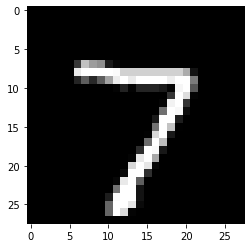

In [34]:
tes_image = y_test[3000].reshape(28,28)
plt.imshow(tes_image)

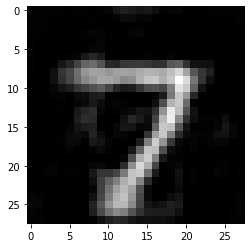

In [37]:
pred_image = pred_test[3000].reshape(28,28)
plt.imshow(pred_image)

# Result Visualization

In [38]:
new_model_mse = list()
for idx in [5,3000,-1]:
    new_model_mse.append(np.square(np.subtract(pred_test[idx],y_test[idx])).mean())

In [39]:
old_model_mse = list()
for idx in [5,3000,-1]:
    old_model_mse.append(np.square(np.subtract(old_pred_test[idx],y_test[idx])).mean())

In [40]:
new_model_ssim = list()
for idx in [5,3000,-1]:
    tes_valid = tf.dtypes.cast(y_test[idx].reshape(28,28,1),tf.float64)
    tes2_valid = tf.dtypes.cast(pred_test[idx].reshape(28,28,1),tf.float64)

    fake_img_a = tf.compat.v1.get_variable('a', initializer=tes_valid)
    fake_img_b = tf.compat.v1.get_variable('b', initializer=tes2_valid)
    costs = tf.image.ssim(fake_img_a, fake_img_b, 1.)
    costs = tf.reduce_mean(costs)
    new_model_ssim.append(costs)
    print(costs)


tf.Tensor(0.74761266, shape=(), dtype=float32)
tf.Tensor(0.64979446, shape=(), dtype=float32)
tf.Tensor(0.35736987, shape=(), dtype=float32)


In [41]:
old_model_ssim = list()
for idx in [5,3000,-1]:
    tes_valid = tf.dtypes.cast(y_test[idx].reshape(28,28,1),tf.float64)
    tes2_valid = tf.dtypes.cast(old_pred_test[idx].reshape(28,28,1),tf.float64)

    fake_img_a = tf.compat.v1.get_variable('a', initializer=tes_valid)
    fake_img_b = tf.compat.v1.get_variable('b', initializer=tes2_valid)
    costs = tf.image.ssim(fake_img_a, fake_img_b, 1.)
    costs = tf.reduce_mean(costs)
    old_model_ssim.append(costs)
    print(costs)


tf.Tensor(0.74761266, shape=(), dtype=float32)
tf.Tensor(0.64979446, shape=(), dtype=float32)
tf.Tensor(0.35736987, shape=(), dtype=float32)


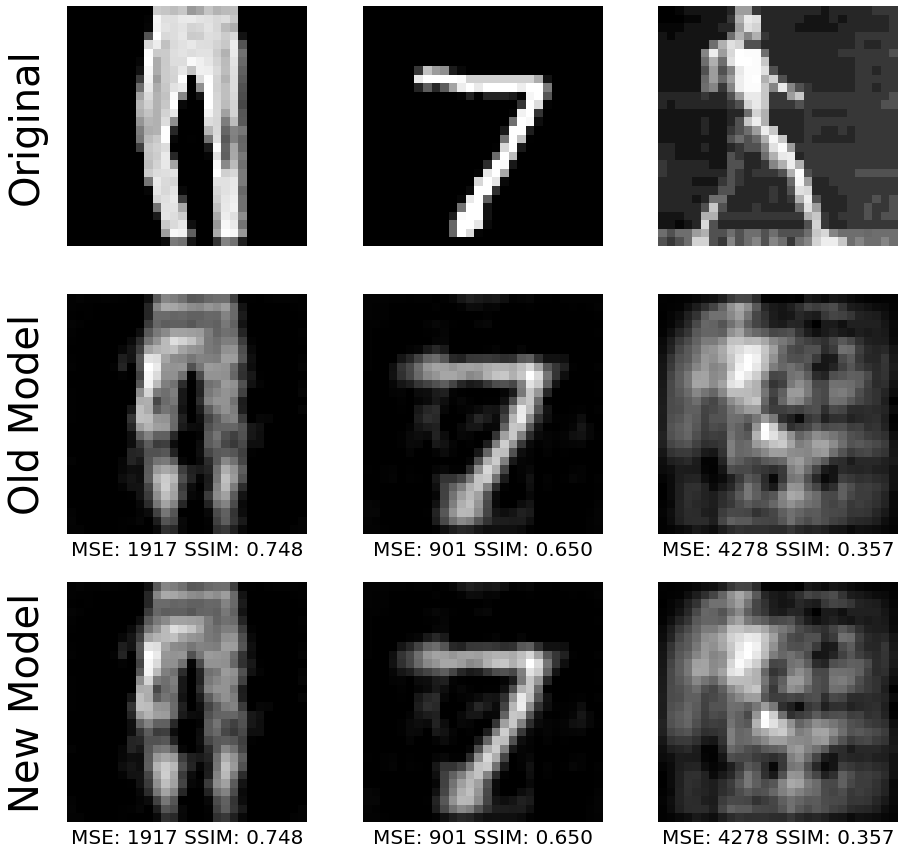

In [42]:
rows, cols = 3, 3
x_size, y_size = 20, 40
x_pad, y_pad = 6, 20

# Set subplot size
f1, ax_arr1 = plt.subplots(rows, cols, figsize=(15, 15))

def add_to_plot(img, rows, cols, idx, 
                x_label=None, y_label=None, x_size=None, y_size=None, x_pad=None, y_pad=None,):
    plt.subplot(rows, cols, idx)
    plt.imshow(img)
    if x_label: plt.xlabel(x_label, size = x_size, labelpad = x_pad)
    if y_label: plt.ylabel(y_label, size = y_size, labelpad = y_pad)
    plt.xticks([]); plt.yticks([])


# Original
ori_fashion = y_test[5].reshape(out_dim,out_dim)
ori_mnist = y_test[3000].reshape(out_dim,out_dim)
ori_muy = y_test[-1].reshape(out_dim,out_dim)

add_to_plot(ori_fashion, rows, cols, 1, y_label='Original', y_size=y_size, y_pad=y_pad)
add_to_plot(ori_mnist, rows, cols, 2 )
add_to_plot(ori_muy, rows, cols, 3)

# Old Model
old_model_fashion = old_pred_test[5].reshape(out_dim,out_dim)
old_model_mnist = old_pred_test[3000].reshape(out_dim,out_dim)
old_model_muy = old_pred_test[-1].reshape(out_dim,out_dim)

add_to_plot(old_model_fashion, rows, cols, 4, y_label='Old Model',
            x_label='MSE: {} SSIM: {}'.format("%.f" % old_model_mse[0],"%.3f" % old_model_ssim[0]), 
            y_size=y_size, y_pad=y_pad, x_size=x_size, x_pad=x_pad)
add_to_plot(old_model_mnist, rows, cols, 5,  
            x_label='MSE: {} SSIM: {}'.format("%.f" % old_model_mse[1],"%.3f" % old_model_ssim[1]), 
            x_size=x_size, x_pad=x_pad)
add_to_plot(old_model_muy, rows, cols, 6,
            x_label='MSE: {} SSIM: {}'.format("%.f" % old_model_mse[2],"%.3f" % old_model_ssim[2]), 
            x_size=x_size, x_pad=x_pad)

# New Model
new_model_fashion = pred_test[5].reshape(out_dim,out_dim)
new_model_mnist = pred_test[3000].reshape(out_dim,out_dim)
new_model_muy = pred_test[-1].reshape(out_dim,out_dim)

add_to_plot(new_model_fashion, rows, cols, 7, y_label='New Model', y_size=y_size, y_pad=y_pad,
           x_label='MSE: {} SSIM: {}'.format("%.f" % new_model_mse[0],"%.3f" % new_model_ssim[0]), 
           x_size=x_size, x_pad=x_pad)
add_to_plot(new_model_mnist, rows, cols, 8,
            x_label='MSE: {} SSIM: {}'.format("%.f" % new_model_mse[1],"%.3f" % new_model_ssim[1]), 
            x_size=x_size, x_pad=x_pad)
add_to_plot(new_model_muy, rows, cols, 9,
            x_label='MSE: {} SSIM: {}'.format("%.f" % new_model_mse[2],"%.3f" % new_model_ssim[2]), 
            x_size=x_size, x_pad=x_pad)

plt.savefig('Comparing Result')

In [ ]:
# rows,cols = 3,3
# f, ax_arr = plt.subplots(rows,cols, figsize=(15,15))
# i = 0

# for result,label in zip([y_test,old_pred_test,pred_test],['Original','Old Model','New Model']):
#         for image in zip([0,3000,-1]):
#             i+=1
#             plt.subplot(rows,cols,i)
#             plt.xlabel(label)
#             this_image =  result[image].reshape(out_dim,out_dim)        
#             plt.imshow(this_image)
#             axes_off()


In [ ]:
# rows,cols = 4,4
# f, ax_arr = plt.subplots(rows,cols, figsize=(20,20))
# i = 1
# offsets = [0,3000-2*cols]

# for row in range(1,rows+1,2):
#         for col in range(cols):
#             i = (row-1)*cols + (col+1)
#             offset = offsets[(row-1)//2]
#             if row>1 and col>2: offset+=4

#             plt.subplot(rows,cols,i)
#             if type(y_valid) == list:
#                 this_image =  y_valid[offset+i-1].reshape(out_dim,out_dim)
#             else:
#                 this_image =  y_valid[offset+i-1].reshape(out_dim,out_dim)        
#             plt.imshow(this_image)
#             axes_off()

#             plt.subplot(rows,cols,i+cols)
#             plt.imshow(pred_test[offset+i-1].reshape(out_dim,out_dim))
#             axes_off()